In [1]:
import yaml
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from umap.umap_ import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

/opt/homebrew/anaconda3/envs/IS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load YAML data
def load_yaml_articles(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        articles = yaml.safe_load(file)
    return articles


articles = load_yaml_articles('articles.yaml')

In [3]:
from urllib.parse import urlparse
import re

def extract_topics_from_url(url, skip_last_n=2):
    path = urlparse(url).path
    parts = [part for part in path.strip("/").split("/") if part]

    if len(parts) > skip_last_n:
        topics = parts[:-skip_last_n]
    else:
        topics = []

    # Replace hyphens with spaces, remove numbers if needed, clean up
    topics = [re.sub(r'[-_]+', ' ', topic) for topic in topics]

    return topics


In [4]:
# Assuming articles are loaded like this:
# articles = load_yaml_articles('articles.yaml')

for article in articles:
    article['url_topics'] = extract_topics_from_url(article['url'])

# Verify:
print(articles[0]['url_topics'])

['svet', 'preberite tudi']


In [5]:
num = 2
print(articles[num].get('topics'))
print(articles[num].get('url'))

slovenija
https://www.rtvslo.si/slovenija/preberite-tudi/v-veljavi-podrazitve-napotitev-delavcev/693324


In [6]:
# Extract representative texts from articles
def get_article_text(article):
    text_parts = [
        article.get('title', ''),
        article.get('lead', ''),
        ' '.join(article.get('paragraphs', [])),
    ]
    return ' '.join(text_parts)
    
# Prepare data
texts = [get_article_text(article) for article in tqdm(articles, desc="Processing articles")]


Processing articles: 100%|██████████| 29493/29493 [00:00<00:00, 374885.92it/s]


In [7]:
# ----------- TF-IDF Embeddings ----------- #
print("Generating TF-IDF embeddings...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
tfidf_embeddings = tfidf_vectorizer.fit_transform(texts)

Generating TF-IDF embeddings...


In [8]:
# ----------- SBERT Embeddings ----------- #
#print("Generating SBERT embeddings...")
#sbert_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
#sbert_embeddings = sbert_model.encode(texts, batch_size=64, show_progress_bar=True)

#np.save('sbert_embeddings.npy', sbert_embeddings)

In [8]:
sbert_embeddings = np.load('sbert_embeddings.npy')

In [10]:
# # ----------- UMAP Reduction ----------- #
# print("Reducing dimensionality with UMAP...")
# umap_reducer = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')

# print("UMAP on TF-IDF embeddings...")
# tfidf_umap = umap_reducer.fit_transform(tfidf_embeddings)

# print("UMAP on SBERT embeddings...")
# sbert_umap = umap_reducer.fit_transform(sbert_embeddings)

# np.save('sbert_umap.npy', sbert_umap)
# np.save('tfidf_umap.npy', tfidf_umap)


In [9]:
sbert_umap = np.load('sbert_umap.npy')
tfidf_umap = np.load('tfidf_umap.npy')

t-SNE tends to form tight, visually appealing clusters. It emphasizes local neighborhood relationships strongly. While visually clearer, it can over-emphasize local neighborhoods, potentially fragmenting larger semantic clusters into artificially small subgroups.
UMAP achieves a balance between local and global structure, providing a slightly more faithful semantic representation at the expense of somewhat less visually dramatic cluster separation compared to t-SNE. UMAP embeddings typically preserve semantic continuity and relationships between clusters better than t-SNE.

Fitting PCA...


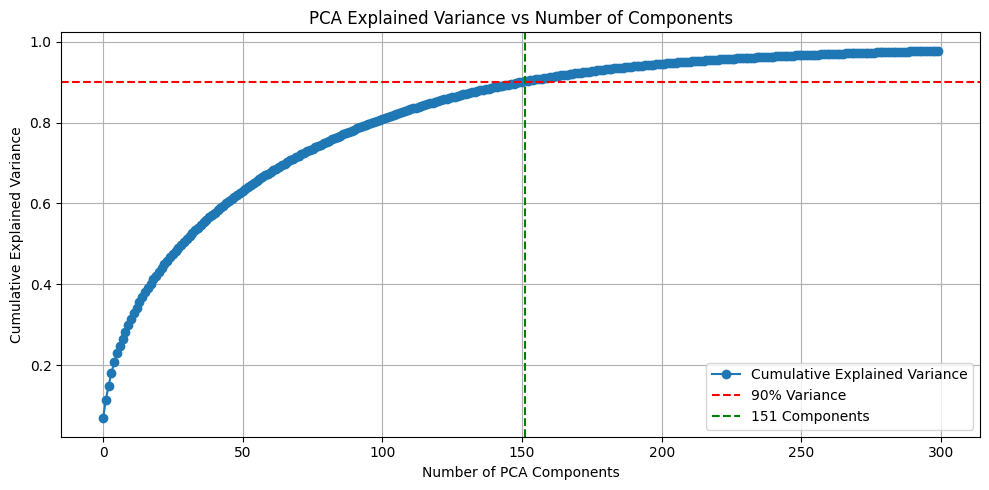

✅ 151 components retain 90% of the variance.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_variance(embeddings, variance_threshold=0.90):
    print("Fitting PCA...")
    pca = PCA(n_components=min(300, embeddings.shape[1]))  # limit to 300 or max dims
    pca.fit(embeddings)

    # Cumulative sum of explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find how many components are needed to reach the threshold
    num_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance, marker='o', label='Cumulative Explained Variance')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{int(variance_threshold * 100)}% Variance')
    plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Components')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance vs Number of Components')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"✅ {num_components} components retain {variance_threshold*100:.0f}% of the variance.")
    return num_components

n_components_needed = plot_pca_variance(sbert_embeddings, variance_threshold=0.90)

In [11]:
from sklearn.decomposition import PCA

# Reduce SBERT embeddings to ~50D before HDBSCAN
pca = PCA(n_components=150, random_state=42)
sbert_reduced = pca.fit_transform(sbert_embeddings)

# TODO: for tfidf
# from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=100, random_state=42)
# tfidf_reduced = svd.fit_transform(tfidf_matrix)

# clusterer = hdbscan.HDBSCAN(min_cluster_size=70)
# tfidf_clusters = clusterer.fit_predict(tfidf_reduced)


In [29]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder

# ----------- Clustering with HDBSCAN ----------- #
print("Clustering with HDBSCAN...")
# clusterer_tfidf = hdbscan.HDBSCAN(min_cluster_size=70, metric='euclidean')
# tfidf_clusters = clusterer_tfidf.fit_predict(tfidf_embeddings)

# Cluster with precomputed cosine distances
# TODO: min cluster size
#clusterer_sbert = hdbscan.HDBSCAN(min_cluster_size=70, metric='euclidean')
clusterer_sbert = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
# TODO: for report
#sbert_clusters = clusterer_sbert.fit_predict(sbert_umap)
sbert_clusters = clusterer_sbert.fit_predict(sbert_reduced)

# ----------- Evaluation Metrics ----------- #
def evaluate_clusters(embeddings_2d, labels, embedding_type):
    mask = labels != -1  # Exclude noise points for fair evaluation
    if np.sum(mask) < 2:
        print(f"{embedding_type}: Not enough clustered points for evaluation.")
        return None, None

    silhouette = silhouette_score(embeddings_2d[mask], labels[mask])
    
    davies_bouldin = davies_bouldin_score(embeddings_2d[mask], labels[mask])
    print(f"{embedding_type} Silhouette Score: {silhouette:.3f}")
    print(f"{embedding_type} Davies-Bouldin Index: {davies_bouldin:.3f}")
    return silhouette, davies_bouldin

#print("\nEvaluating TF-IDF clusters:")
#evaluate_clusters(tfidf_embeddings, tfidf_clusters, "TF-IDF")

#print("\nEvaluating SBERT clusters:")
#evaluate_clusters(sbert_embeddings, sbert_clusters, "SBERT")

topic_strings = [
    "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
    for article in articles
]
le = LabelEncoder()
topic_labels = le.fit_transform(topic_strings)

# Evaluate clustering
ari_score = adjusted_rand_score(topic_labels, sbert_clusters)
nmi_score = normalized_mutual_info_score(topic_labels, sbert_clusters)
print(ari_score, nmi_score)

Clustering with HDBSCAN...
0.00523121974052527 0.04518291916030571


In [17]:
# # from sklearn.metrics import silhouette_score
# # from sklearn.preprocessing import LabelEncoder


# # # MMC labels silhouette
# topic_labels = [
#     "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
#     for article in articles
# ]
# # # topic_labels = [
# # #     article['url_topics'][0] if len(article['url_topics']) >= 1 else "no-topic"
# # #     for article in articles
# # # ]
# # print(topic_labels[:5])

# le = LabelEncoder()
# url_topics = le.fit_transform(topic_labels)

# # sbert_silhouette = silhouette_score(sbert_embeddings, topic_labels_encoded)

# # print(f"Silhouette Score (SBERT embeddings vs. URL topics): {sbert_silhouette:.3f}")

# # sbert_silhouette_orig = silhouette_score(sbert_embeddings, sbert_clusters)
# # print(f"Silhouette Score (SBERT embeddings vs. Clusters): {sbert_silhouette_orig:.3f}")

# # tfidf_silhouette = silhouette_score(tfidf_embeddings, topic_labels_encoded)

# # print(f"Silhouette Score (TF-IDF embeddings vs. URL topics): {tfidf_silhouette:.3f}")

# # tfidf_silhouette_orig = silhouette_score(tfidf_embeddings, tfidf_clusters)
# # print(f"Silhouette Score (TF-IDF embeddings vs. Clusters): {tfidf_silhouette_orig:.3f}")

# from collections import defaultdict
# from gensim.models import CoherenceModel
# from gensim.corpora import Dictionary
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# import nltk
# import random

# nltk.download('punkt')

# # Setup stopwords & lemmatizer
# nltk.download('stopwords')
# nltk.download('wordnet')

# stop_words = set(stopwords.words('slovene'))

# def preprocess_for_coherence(texts, stopwords=None):
#     # Basic preprocessing: tokenize and lower
#     tokenized = []
#     for text in texts:
#         tokens = word_tokenize(text.lower())
#         if stopwords:
#             tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
#         tokenized.append(tokens)
#     return tokenized

# def compute_npmi(groups: dict, all_texts: list, stopwords=None, top_n=10):
#     """
#     groups: dict[group_id] = list of indices
#     all_texts: list of raw article texts
#     """
#     results = {}
#     all_tokenized = preprocess_for_coherence(all_texts, stopwords)

#     for group_id, indices in groups.items():
#         group_texts = [all_tokenized[i] for i in indices]

#         if len(group_texts) < 3:
#             continue  # Skip tiny groups

#         # Create dictionary and corpus
#         dictionary = Dictionary(group_texts)
#         corpus = [dictionary.doc2bow(text) for text in group_texts]

#         # 👉 Extract top-N words for the group as a "topic"
#         word_freq = defaultdict(int)
#         for doc in group_texts:
#             for word in doc:
#                 word_freq[word] += 1

#         top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
#         topic = [word for word, _ in top_words]

#         # 👇 Now pass topic manually!
#         cm = CoherenceModel(
#             topics=[topic],               # this is key!
#             texts=group_texts,
#             corpus=corpus,
#             dictionary=dictionary,
#             coherence='c_npmi',
#             topn=top_n
#         )

#         npmi_score = cm.get_coherence()
#         results[group_id] = npmi_score

#     return results


# # 🧪 Example usage
# # Assuming you have:
# # - `texts`: list of full article texts
# # - `sbert_clusters`: clustering labels from HDBSCAN
# # - `url_topics`: list of topic labels (strings, one per article)

# # Group indices by HDBSCAN cluster
# cluster_groups = defaultdict(list)
# for i, label in enumerate(sbert_clusters):
#     if label != -1:
#         cluster_groups[label].append(i)

# # Group indices by URL topic
# label_groups = defaultdict(list)
# for i, label in enumerate(url_topics):
#     label_groups[label].append(i)

# # Optional: use Slovene stopwords

# print("\n🔍 Calculating NPMI for clusters...")
# npmi_clusters = compute_npmi(cluster_groups, texts, stopwords=list(stop_words))

# print("\n🔍 Calculating NPMI for URL labels...")
# npmi_labels = compute_npmi(label_groups, texts, stopwords=list(stop_words))

# # Compare averages
# import numpy as np

# mean_npmi_clusters = np.mean(list(npmi_clusters.values()))
# mean_npmi_labels = np.mean(list(npmi_labels.values()))

# print(f"\n📊 Average NPMI (Clusters): {mean_npmi_clusters:.4f}")
# print(f"📊 Average NPMI (URL Topics): {mean_npmi_labels:.4f}")

# if mean_npmi_clusters > mean_npmi_labels:
#     print("✅ HDBSCAN clusters show higher semantic coherence.")
# else:
#     print("ℹ️ URL topic labels are more coherent based on NPMI.")


silhouette is bad for high dimensional space, overlaps, irregular shapes...

In [30]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def draw_points(fig, subplot_title, col, umap_embeddings, clusters, titles, categories=None, legendgroup=None):
    df = pd.DataFrame({
        'x': umap_embeddings[:, 0],
        'y': umap_embeddings[:, 1],
        'cluster': clusters.astype(str),
        'title': titles,
    })

    if categories is not None:
        df['category'] = categories
        color_col = 'category'
    else:
        color_col = 'cluster'

    # Unique values for coloring
    values = df[color_col].unique()
    values.sort()

    for val in values:
        sub_df = df[df[color_col] == val]
        fig.add_trace(
            go.Scattergl(
                x=sub_df['x'],
                y=sub_df['y'],
                mode='markers',
                name=str(val),
                marker=dict(size=4),
                legendgroup=color_col,  # Separate legend group
                showlegend=True,
                hovertext=sub_df['title'],
                hoverinfo='text',
            ),
            row=1,
            col=col
        )

    fig.update_xaxes(title_text="UMAP 1", row=1, col=col)
    fig.update_yaxes(title_text="UMAP 2", row=1, col=col)
    fig.layout.annotations[col - 1].update(text=subplot_title)


In [31]:
print(len(set(sbert_clusters)))
#print(len(set(tfidf_clusters)))

4


In [32]:
categories = [
    article['url_topics'][0] if len(article['url_topics']) >= 1 else "no-topic"
    for article in articles
]

from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Clusters", "Categories"))

# Left: Clusters
draw_points(fig, "Clusters", col=1, 
            umap_embeddings=sbert_umap,
            clusters=sbert_clusters,
            titles=[article['title'] for article in articles],
            categories=None,
            legendgroup="cluster")

# Right: Categories
draw_points(fig, "Categories", col=2, 
            umap_embeddings=sbert_umap,
            clusters=sbert_clusters,  # still required for shape
            titles=[article['title'] for article in articles],
            categories=categories,
            legendgroup="category")

fig.update_layout(
    height=500,
    width=1000,
    title_text="Clusters vs. Categories",
    legend_title_text="Legend",
)

fig.show()


In [22]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import numpy as np

# Setup stopwords & lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('slovene'))  # change language if necessary
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

def extract_clean_keywords(texts, clusters, top_n=10):
    unique_clusters = np.unique(clusters[clusters >= 0])

    keywords_per_cluster = {}

    for cluster_label in unique_clusters:
        cluster_texts = [preprocess_text(texts[i]) for i in range(len(texts)) if clusters[i] == cluster_label]

        # TF-IDF on processed texts (stopwords already removed)
        vectorizer = TfidfVectorizer(max_features=top_n)
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        keywords = vectorizer.get_feature_names_out()

        keywords_per_cluster[cluster_label] = keywords
        print(f"Cluster {cluster_label} keywords: {', '.join(keywords)}")

    return keywords_per_cluster

# Example Usage:
extract_clean_keywords(texts, sbert_clusters, top_n=10)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matjeez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/matjeez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cluster 0 keywords: gaze, gazi, izrael, izraelska, izraelske, ljudi, najmanj, ubitih, več, vojska
Cluster 1 keywords: igre, lahko, mesto, minuti, slovenija, tekmi, točk, več, zdaj, zelo
Cluster 2 keywords: dejal, napadu, oblasti, rusija, ruske, ruskih, sile, ukrajini, ukrajinske, več


{0: array(['gaze', 'gazi', 'izrael', 'izraelska', 'izraelske', 'ljudi',
        'najmanj', 'ubitih', 'več', 'vojska'], dtype=object),
 1: array(['igre', 'lahko', 'mesto', 'minuti', 'slovenija', 'tekmi', 'točk',
        'več', 'zdaj', 'zelo'], dtype=object),
 2: array(['dejal', 'napadu', 'oblasti', 'rusija', 'ruske', 'ruskih', 'sile',
        'ukrajini', 'ukrajinske', 'več'], dtype=object)}

In [97]:
# cluster keywords vs random

import random
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words=list(stop_words), max_features=5000)
    X = vectorizer.fit_transform(texts)
    summed_tfidf = np.asarray(X.sum(axis=0)).flatten()
    top_indices = summed_tfidf.argsort()[::-1][:top_n]
    return [vectorizer.get_feature_names_out()[i] for i in top_indices]

def compare_cluster_vs_random(texts, cluster_labels, target_cluster_id, top_n=10):
    # Get texts in target cluster
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == target_cluster_id]
    cluster_texts = [texts[i] for i in cluster_indices]
    
    if len(cluster_texts) < 5:
        print(f"Cluster {target_cluster_id} is too small ({len(cluster_texts)} docs) for meaningful comparison.")
        return
    
    # Get same number of random texts (excluding target cluster)
    all_indices = set(range(len(texts)))
    non_cluster_indices = list(all_indices - set(cluster_indices))
    random_indices = random.sample(non_cluster_indices, len(cluster_indices))
    random_texts = [texts[i] for i in random_indices]
    
    # Extract keywords
    cluster_keywords = get_tfidf_keywords(cluster_texts, top_n)
    random_keywords = get_tfidf_keywords(random_texts, top_n)
    
    # Output
    print(f"\n📌 Top {top_n} keywords for **Cluster {target_cluster_id}** ({len(cluster_texts)} docs):")
    print("   ", ", ".join(cluster_keywords))

    print(f"\n🎲 Top {top_n} keywords for **Random sample** of same size:")
    print("   ", ", ".join(random_keywords))

    print("\n✅ If the cluster keywords are more thematically coherent, your clustering has meaningful semantic structure.")

# Example usage:
# Assume `texts` are your original documents used for embedding
# and `sbert_clusters` are your HDBSCAN cluster labels

compare_cluster_vs_random(texts, sbert_clusters, target_cluster_id=1, top_n=10)



📌 Top 10 keywords for **Cluster 1** (143 docs):
    odstotkov, dolarjev, delnice, rast, več, odstotka, bitcoin, letos, delnic, ecb

🎲 Top 10 keywords for **Random sample** of same size:
    leta, več, igre, lahko, evrov, dejal, skokov, kjer, 10, veliko

✅ If the cluster keywords are more thematically coherent, your clustering has meaningful semantic structure.


In [71]:
from transformers import pipeline

# Summarization pipeline
generator = pipeline('text2text-generation', model='google/flan-t5-base')

def keywords_to_summary(keywords):
    prompt = "Summarize the topic: " + ', '.join(keywords)
    summary = generator(prompt, max_length=30, do_sample=False)[0]['generated_text']
    return summary

# Example usage:
keywords = ['energy', 'climate', 'renewable', 'solar', 'investment']
summary = keywords_to_summary(keywords)
print(summary)


Device set to use mps:0


climate change renewable energy investment
